In [ ]:
import os
import json
import torch
import re
import time
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from data.prompts import prompts

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
years_prompt_template = prompts.NORAG_RESPONSE["years"].strip()

In [ ]:
# Define a helper function to split a list into smaller batches.
def chunkify(lst, chunk_size):
    """Yield successive chunk_size-sized chunks from lst."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

def run_model_batch(prompts_list, temperature, max_new_tokens, tokenizer, model, device):
    """
    Process a batch of prompts with the model.
    For decoder-only models, ensures padding_side is set to 'left'.
    Uses sampling (do_sample=True) if temperature > 0.
    """
    tokenizer.padding_side = "left"
    # When using accelerate with device_map, do not manually move inputs,
    # but here we assume that 'device' is correctly set (e.g., torch.device("cuda"))
    inputs = tokenizer(prompts_list, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            pad_token_id=tokenizer.eos_token_id,
        )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

def run_model_batches(all_prompts, temperature, max_new_tokens, tokenizer, model, device, batch_size=16):
    """
    Splits the list of all prompts into batches and processes each batch.
    Returns a combined list of outputs.
    """
    all_outputs = []
    for i in range(0, len(all_prompts), batch_size):
        batch_prompts = all_prompts[i : i + batch_size]
        outputs = run_model_batch(batch_prompts, temperature, max_new_tokens, tokenizer, model, device)
        all_outputs.extend(outputs)
    return all_outputs

# Helper function: Extract answer from generated text.
def extract_answer(generated_text):
    if "Answer:" in generated_text:
        return generated_text.split("Answer:")[-1].strip()
    return generated_text.strip()

# Helper function: Extract proposed confidence from a response.
def extract_confidence(response):

    m = re.search(r'Proposed\s+confidence:\s*([\d\.]+)', response)
    if m:
        try:
            return float(m.group(1))
        except ValueError:
            return None
    return None

# Helper function: For numerical answers, compare by normalizing numbers.
def is_correct(model_answer, ground_truth):
    def normalize_number(num_str):
        try:
            num = float(num_str)
            if num.is_integer():
                return str(int(num))
            else:
                return f"{num:.1f}"
        except ValueError:
            return num_str.strip().lower()
    gt_norm = normalize_number(ground_truth)
    # Extract numbers from the model answer.
    numbers = re.findall(r'\b\d+(?:\.\d+)?\b', model_answer)
    norm_numbers = [normalize_number(num) for num in numbers]
    return gt_norm in norm_numbers

def extract_generated_after_prompt(full_text, prompt):
    """
    If full_text starts with prompt, return only the text after prompt.
    Otherwise, return the extracted answer using extract_answer.
    """
    if full_text.startswith(prompt):
        return full_text[len(prompt):].strip()
    return extract_answer(full_text)

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) N
Token is valid (permission: fineGrained).
The token `icl testing` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `icl te

In [ ]:
model_name_or_path = "meta-llama/Llama-3.1-8B-Instruct"

In [ ]:
cache_dir = ""

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, cache_dir=cache_dir)
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    cache_dir=cache_dir,
    torch_dtype=torch.float16
)
#tokenizer.pad_token = tokenizer.eos_token # for 8b instruct
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, cache_dir=cache_dir)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [ ]:
data_path = ""
data_file = "full_label_qa_year_588.json"
file_path = f"{data_path}/{data_file}"

with open(file_path, "r") as f:
    dataset = json.load(f)

print(f"Loaded {len(dataset)} year QA pairs.")

Loaded 588 year QA pairs.


#### Regular

In [ ]:
# For each QA pair, run 16 samples at T=0.5.
results = []
num_samples = 16
for idx, entry in enumerate(dataset):
    question = entry["Question"]
    ground_truth = entry["StandardAnswer"]
    prompt = all_prompts[idx]

    current_entry = {
        "Question": question,
        "StandardAnswer": ground_truth,
        "Prompt": prompt
    }

    # Deterministic output.
    det_output = deterministic_outputs[idx]
    det_answer = extract_answer(det_output)
    det_correct = is_correct(det_answer, ground_truth)
    current_entry["DeterministicAnswer"] = det_answer
    current_entry["DeterministicCorrect"] = det_correct

    # Generate 16 samples in batches
    sample_prompts = [prompt] * num_samples
    sampled_outputs = run_model_batches(
        sample_prompts,
        #temperature=0.5,
        temperature=0.7,
        max_new_tokens=50,
        tokenizer=tokenizer,
        model=model,
        device=device,
        batch_size=16  # Adjust batch_size as needed to fit within GPU memory.
    )

    # Process the outputs
    sampled_answers = [extract_generated_after_prompt(out, prompt) for out in sampled_outputs]
    sample_correct = sum(is_correct(ans, ground_truth) for ans in sampled_answers)
    prob = sample_correct / num_samples
    current_entry["SampledAnswers"] = sampled_answers
    current_entry["SampledCorrectCount"] = sample_correct
    current_entry["SampledProbability"] = prob

    # Classification: adjust thresholds as desired.
    if prob >= 0.85:
        classification = "highly known"
    elif 0 < prob <= 0.3:
        classification = "maybe known"
    elif prob > 0:
        classification = "weakly known"
    else:
        classification = "unknown"
    current_entry["Classification"] = classification

    results.append(current_entry)
    print(f"Processed: {question[:50]}... -> {classification} (p={prob:.2f})")

print(f"Completed classification on {len(results)} QA pairs.")

Processed: In which year did Subhash Sureshchandra Deshmukh t... -> unknown (p=0.00)
Processed: In which year was the album 'Lover Man' by Duke Jo... -> weakly known (p=0.19)
Processed: In which year was the Tanzer 10 sailboat first bui... -> weakly known (p=0.12)
Processed: In which year was the Hutch Award created to honor... -> highly known (p=0.75)
Processed: In which year was the species Penicillium ribium d... -> unknown (p=0.00)
Processed: In which year was the album 'Lake Street Dive' by ... -> unknown (p=0.00)
Processed: In which year was Picfair officially launched as a... -> unsure (p=0.38)
Processed: In which year did the Evangelical Lutheran Church ... -> weakly known (p=0.12)
Processed: In which year was Thai professional footballer Phu... -> weakly known (p=0.12)
Processed: In which year did Iraqi officials announce the kil... -> highly known (p=0.94)
Processed: In which year did Nick Wells retire from professio... -> unknown (p=0.00)
Processed: In which year were the ca

In [ ]:
# Save the experiment results to a JSON file.
save_filename = f"evaluation_result_year_llama8b_instruct_{len(results)}_T0.7.json"
save_filepath = os.path.join(data_path, save_filename)

with open(save_filepath, "w") as f:
    json.dump(results, f, indent=2)

print(f"Evaluation complete. Results saved to {save_filepath}")

Evaluation complete. Results saved to /content/drive/MyDrive/LLM/ICL/StanfordClashEval-main/data/dataset/evaluation_result_year_llama8b_instruct_588_T0.7.json


Distribution of classifications:
Classification
unknown         339
weakly known    138
highly known     85
unsure           26
Name: count, dtype: int64


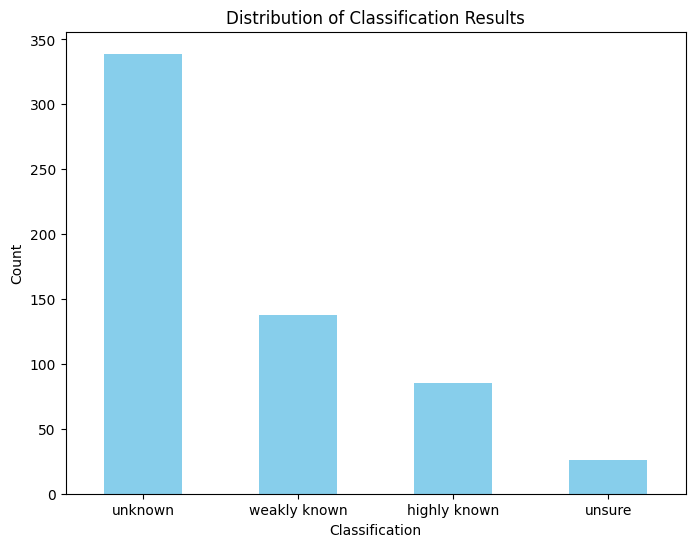

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Replace with the path to your evaluation results file.
result_file = ""

with open(result_file, "r") as f:
    results = json.load(f)

# Convert the results to a DataFrame.
df = pd.DataFrame(results)

# Compute the distribution of the 'Classification' column.
distribution = df["Classification"].value_counts()

print("Distribution of classifications:")
print(distribution)

# Plot the distribution as a bar chart.
plt.figure(figsize=(8, 6))
distribution.plot(kind="bar", color="skyblue")
plt.title("Distribution of Classification Results")
plt.xlabel("Classification")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()